# Parameter estimation
Tailored to work with the data produced after running the following notbooks:
* Simulate_QRAGE_with_MRZERO.ipynb
* preprocessing_simulated_data.ipynb
* reconstruction_simulated_data.ipynb

In [1]:
# check for dependencies
import importlib.util

packages = ['joblib', 'git']
for package in packages:
    spec = importlib.util.find_spec(package)
    if (spec==None):
        print('Need to isntall package {}.'.format(package))
        if package=='joblib':
            %pip install joblib
        elif package=='git':
            %pip install gitpython

In [2]:
import os
import git

# clone qrage, if not present
if( not os.path.isdir('../qrage') ):
    print('qrage not installed, cloning ...')
    git.Git('../').clone('https://jugit.fz-juelich.de/inm-4/mr/qrage.git')

# clone parameter estimation, if not present
if( not os.path.isdir('../parameter-estimation') ):
    print('parameter-estimation not installed, cloning ...')
    git.Git('../').clone('https://jugit.fz-juelich.de/inm-4/mr/parameter-estimation.git')

In [3]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import sys

sys.path.insert(0, "../src")
sys.path.insert(0, '../qrage')
sys.path.insert(0, '../parameter-estimation')

from qrage.sequence.qrage import QRAGE

import h5py

import matplotlib.pyplot as plt
import numpy as np
# import pypulseq as pp

# from types import SimpleNamespace
from scipy.ndimage import binary_fill_holes

from juart.vis import MultiPlotter

from parest.relaxometry.lm2d import lm_2D_VP

## Load Sequence Parameter

In [4]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'qrage_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_sets = f['num_sets'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTI = f['dTI'][...]
    TI0 = f['TI0'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]
    TR = f['TR'][...]

## Load Reonstructed Image

In [5]:
nUS = 8
iS = 1

In [6]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_image_fname =  os.path.join(filepath, 'LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [7]:
with h5py.File(h5_image_fname, "r", libver="latest", swmr=True) as h5_image_file:
    z_image = h5_image_file["x"][...]

## Parameter Estimation
Copied from "Read_Signals.ipynb" under "SimulationStudies/ME_MPNRAGE". 

In [8]:
# Set additional parameters
nTI = num_sets
# dTI = qrage.dTI
# TI0 = qrage.TI0
nTE = num_echoes
# dTE = qrage.dTE
# TE0 = qrage.TE0
FA = 5                   # This is currently fixed int the qrage sequence

In [9]:
print('Number of inversions = {}'.format(nTI))
print('Inversion time TI0 = {}'.format(TI0))
print('Delta inversion time DTI = {}'.format(dTI))
print('Number of contrasts = {}'.format(nTE))
print('Echo time TE0 = {}'.format(TE0))
print('Delta echo time DTE = {}'.format(dTE))
print('Excitation flip ange FA = {}'.format(FA))

Number of inversions = 19
Inversion time TI0 = 249.7850000000003
Delta inversion time DTI = 508.80000000000075
Number of contrasts = 9
Echo time TE0 = 3.25
Delta echo time DTE = 2.950000000000003
Excitation flip ange FA = 5


In [10]:
# Magic angle
alpha = np.deg2rad(FA)

In [11]:
# Create mask by thresholding
mask = np.mean(np.abs(z_image), axis=(-2, -1)) > 0.5 * np.max(z_image)

In [12]:
# fill potential holes in the mask
mask = binary_fill_holes(np.squeeze(mask))
mask = mask[:,:,np.newaxis,np.newaxis]

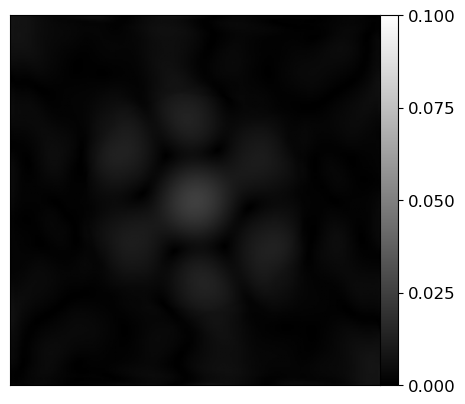

In [13]:
MultiPlotter(np.abs(z_image)[:,:,:,:,0,0], (1,1), axis=(2, 3), vmin=0, vmax=0.1, fig=plt.figure(), cbar=True, cmap='gray')

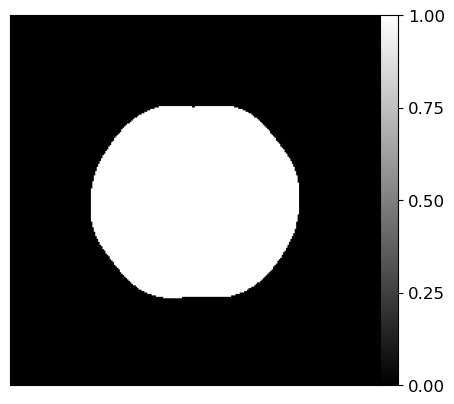

In [14]:
# MultiPlotter(np.transpose(mask,(1,0,2,3)), (1,1), axis=(2, 3), vmin=0, vmax=1, fig=plt.figure(), cbar=True, cmap='gray')
MultiPlotter(mask, (1,1), axis=(2, 3), vmin=0, vmax=1, fig=plt.figure(), cbar=True, cmap='gray')

In [15]:
# do the parameter estimation
ti = np.arange(nTI)[:, None] * dTI + TI0
te = np.arange(nTE)[None, :] * dTE + TE0
tr = TR
m0_est, r1_est, r2_est = lm_2D_VP(z_image[:, :, :, :, :, :], ti, te, tr, constrained=True, s1=1e3, s2=1e1, t1max=1e4, t2max=1e2)

In [16]:
# Create estimations for T1 and T2
R1s = r1_est.real
R2s = r2_est.real
FM = r2_est.imag
MSS = np.abs(m0_est)
# Minv = m2_est
T1s = 1 / R1s
T1s[~np.isfinite(T1s)] = 0  
T2s = 1 / R2s
T2s[~np.isfinite(T2s)] = 0

In [17]:
# Assume constant B1
B1p = 1

In [18]:
# Recreate T1 from T1*
T1est = 1 / (np.squeeze(1/T1s) + np.log( np.cos( np.abs(B1p) * alpha )) / dTI )
T1est = np.expand_dims(T1est, axis=(2,3))

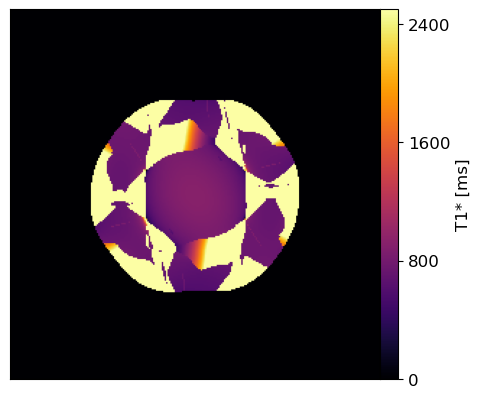

In [19]:
MultiPlotter(T1est * mask, (1, 1), axis=(2,3), vmin=0, vmax=2500, fig=plt.figure(), cmap='inferno', cbar_label='T1* [ms]')

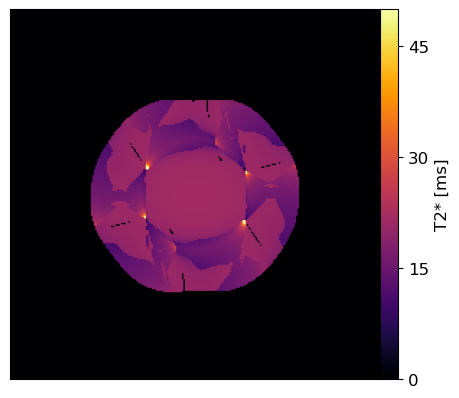

In [20]:
MultiPlotter(T2s * mask, (1, 1), axis=(2, 3), vmin=0, vmax=50, fig=plt.figure(), cmap='inferno', cbar_label='T2* [ms]')